AI able to detect Rock paper scissors

Informations on the dataset are available on the link:
https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset

Help can be found on 
https://medium.com/geekculture/rock-paper-scissors-image-classification-using-cnn-eefe4569b415
https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/




Import the libraries 

In [5]:
import tensorflow as tf 
import zipfile
import os 
import matplotlib.pyplot as plt 
import numpy as np 
import matplotlib.image as mpimp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau 

Kaggle stuff

In [6]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

 98% 441M/452M [00:03<00:00, 124MB/s]
100% 452M/452M [00:03<00:00, 148MB/s]


In [8]:
local_zip = '/content/rock-paper-scissors-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/Rock-Paper-Scissors/'


In [9]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

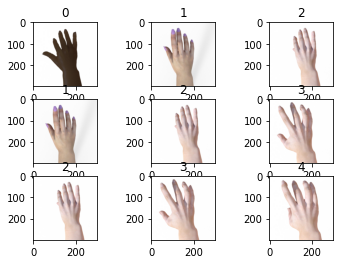

In [10]:
# visualisation of our images of papers
path_train_paper = os.path.join(train_dir, 'paper')
names_images = os.listdir(path_train_paper)

nb_images = 3
fig, ax = plt.subplots(nb_images, nb_images)

for i in range(nb_images):
  for j in range(nb_images):
    pth = os.path.join(path_train_paper, names_images[i+j])
    ax[i, j].imshow(mpimp.imread(pth))
    ax[i, j].set_title(f"{i+j}")


In [17]:
# preprocess data

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                   height_shift_range=0.05, 
                                   width_shift_range=0.05, 
                                   shear_range = 0.1,
                                   fill_mode = 'nearest', 
                                   validation_split=0.2
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255.,
                                        validation_split=0.2
                                        )

test_datagen = ImageDataGenerator(rescale=1./255.)

In [34]:
# prepare the flow

# training
train_generation = train_datagen \
                   .flow_from_directory(directory=train_dir,
                                        target_size=(300, 300), 
                                        batch_size=4, 
                                        class_mode='categorical', 
                                        shuffle=True,
                                        subset="training"
                                        )
# validation   
validation_generation = train_datagen \
                        .flow_from_directory(directory=train_dir,
                                             target_size=(300, 300), 
                                             batch_size=4, 
                                             class_mode='categorical', 
                                             shuffle=True, 
                                             subset="validation")

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


In [19]:
# now define our convulotional neural network 

class Model(tf.keras.Model):
  """
  Definition of the model use
  """

  def __init__(self):
    """
    Initializaiton of our model 
    """
    super().__init__()
    # first layer
    self.conv1 = tf.keras.layers.Conv2D(input_shape=(300, 300, 3), 
                                        filters=16, 
                                        kernel_size=(3, 3), 
                                        kernel_initializer='glorot_uniform', 
                                        activation='relu', 
                                        name='conv1'
                                        )
    self.pool1 = tf.keras.layers.MaxPooling2D(2, 2, name='pool1')
    self.drop1 = tf.keras.layers.Dropout(0.2, name='drop1')

    # second layer 
    self.conv2 = tf.keras.layers.Conv2D(filters=16, 
                                        kernel_size=(3, 3), 
                                        kernel_initializer='glorot_uniform', 
                                        activation='relu', 
                                        name='conv2'
                                        )
    self.pool2 = tf.keras.layers.MaxPooling2D(2, 2, name='pool2')
    self.drop2 = tf.keras.layers.Dropout(0.2, name='drop2')

    # third layer
    self.conv3 = tf.keras.layers.Conv2D(filters=32, 
                                        kernel_size=(3, 3), 
                                        kernel_initializer='glorot_uniform', 
                                        activation='relu', 
                                        name='conv1'
                                        )
    self.pool3 = tf.keras.layers.MaxPooling2D(2, 2, name='pool3')
    self.drop3 = tf.keras.layers.Dropout(0.2, name='drop3')

    # flatten
    self.flat = tf.keras.layers.Flatten(name='flatten')

    # dense layers
    self.dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1')
    self.dense2 = tf.keras.layers.Dense(3, activation='softmax', name='dense2')

  def call(self, input, training=False):

    # conv layer 1 
    output = self.conv1(input)
    output = self.pool1(output)
    if training:
      output = self.drop1(output)

    # conv layer 2
    output = self.conv2(output)
    output = self.pool2(output)
    if training:
      output = self.drop2(output)

    # conv layer 3 
    output = self.conv3(output)
    output = self.pool3(output)
    if training:
      output = self.drop3(output)

    # flat
    output = self.flat(output)

    # dense layers
    output = self.dense1(output)
    output = self.dense2(output)

    return output

In [35]:
tf.config.run_functions_eagerly(False)

# definition of the model
my_model = Model()

In [21]:
# training lasts about one hour

callback = ReduceLROnPlateau(monitor='val_accuracy',
                             patience=2,
                             factor=0.5,
                             min_lr=0.000003)

my_model.compile(loss='categorical_crossentropy',
                 optimizer='adam', 
                 metrics=['accuracy'] 
                 )

my_model.fit(train_generation, 
             epochs=15, 
             validation_data=validation_generation, 
             callbacks=[callback]
             )

Epoch 1/15
504/504 [==============================] - 229s 452ms/step - loss: 0.8696 - accuracy: 0.6012 - val_loss: 0.7892 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 2/15
504/504 [==============================] - 225s 446ms/step - loss: 0.2002 - accuracy: 0.9325 - val_loss: 0.8719 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 3/15
504/504 [==============================] - 226s 447ms/step - loss: 0.0875 - accuracy: 0.9697 - val_loss: 0.3909 - val_accuracy: 0.8492 - lr: 0.0010
Epoch 4/15
504/504 [==============================] - 226s 449ms/step - loss: 0.0733 - accuracy: 0.9762 - val_loss: 0.3749 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 5/15
504/504 [==============================] - 226s 447ms/step - loss: 0.0988 - accuracy: 0.9658 - val_loss: 0.2327 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 6/15
504/504 [==============================] - 231s 457ms/step - loss: 0.0479 - accuracy: 0.9826 - val_loss: 0.2727 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 7/15
504/504 [==========================

In [32]:
# flow for test
test_generation = test_datagen.flow_from_directory(test_dir, 
                                                   target_size=(300, 300), 
                                                   batch_size=4, 
                                                   class_mode='categorical',
                                                   shuffle = False)

# prediction of the model
Y_pred = my_model.predict(test_generation, 372 //4)
y_pred = np.argmax(Y_pred, axis=1)

# classification report
print('\n\nClassification Report\n')
target_names = ['Rock', 'Paper', 'Scissors']
print(classification_report(test_generation.classes, y_pred, target_names=target_names))

Found 372 images belonging to 3 classes.
93/93 [==============================] - 10s 105ms/step


Classification Report

              precision    recall  f1-score   support

        Rock       0.98      0.95      0.97       124
       Paper       1.00      0.98      0.99       124
    Scissors       0.94      0.98      0.96       124

    accuracy                           0.97       372
   macro avg       0.97      0.97      0.97       372
weighted avg       0.97      0.97      0.97       372

